# Centroids Reconstruction on MNIST / Fashion MNIST datasets

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [ ]:
try:
    import tensorflow.compat.v1 as tf 
    tf.disable_v2_behavior()
except:
    import tensorflow as tf

If MNIST dataset is used, run:

In [3]:
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')

Else if Fashion MNIST is used, run:

In [25]:
mnist = tf.keras.datasets.fashion_mnist.load_data()

Divide the data into test set and training set:

In [4]:
data_total = np.reshape(mnist[0][0], [-1,28*28])
maxx = np.reshape(np.amax(data_total, axis = -1), [-1,1])
print(maxx.shape)
data_total = np.reshape(data_total/maxx, [-1,28,28,1])
labels_total = mnist[0][1]
data_train, data_val, labels_train, labels_val = train_test_split(data_total, labels_total, test_size = 0.25, random_state = 42)
data_test = np.reshape(mnist[1][0], [-1,28*28])
maxx = np.reshape(np.amax(data_test, axis = -1), [-1,1])
data_test = np.reshape(data_test/maxx, [-1,28,28,1])
data_test.shape

(60000, 1)


(10000, 28, 28, 1)

Here we use test set:

In [5]:
data_val=data_test
labels_val=mnist[1][1]

In [7]:
data_test.shape

(10000, 28, 28, 1)

Insert the name of the trained model:

In [12]:
ex_name=""
#example ex_name="hyperopt_100_8-8_2020-06-02_68d06"

Create model path:

In [71]:
modelpath = "../models/{}/{}.ckpt".format(ex_name, ex_name)
som_dim=[8,8]

Run the trained model on test set:

In [72]:
tf.reset_default_graph()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(modelpath+".meta")
    saver.restore(sess, modelpath)
    graph = tf.get_default_graph()
    is_t = graph.get_tensor_by_name("is_training/is_training:0")
    z_p = graph.get_tensor_by_name("reconstruction_e/decoder/z_e:0")
    x_hat = graph.get_tensor_by_name("reconstruction_e/decoder/x_hat:0")
    k = graph.get_tensor_by_name("k/k:0")
    z_q = graph.get_tensor_by_name("z_q/z_q:0")
    z_e = graph.get_tensor_by_name("sample_z_e/z_e:0")
    x = graph.get_tensor_by_name("inputs/x:0")
    q = graph.get_tensor_by_name("q/distribution/q:0")
    embeddings = graph.get_tensor_by_name("embeddings/embeddings:0")

    k_all = []
    test_rec_all = []
    test_mse_all = []
    labels_val_all = []
    z_q_all = []
    z_e_all = []
    print("Evaluation...")
    
    z_q_all = sess.run(z_q, feed_dict={x: data_val})
    q = sess.run(q, feed_dict={x:data_val})
    z_e_all = sess.run(z_e, feed_dict={x: data_val})
    k_all = sess.run(k, feed_dict={x: data_val})
    embeddings_e = sess.run(embeddings, feed_dict={x: data_val})
    x_hat_all = np.zeros((som_dim[0],som_dim[1],28,28))
    #for i in range(som_dim[0]):
    #    for j in range(som_dim[1]):
    #        x_hat_o = sess.run(tf.sigmoid(x_hat), feed_dict={is_t: False, x: np.zeros((1, 28,28,1)), z_p: np.expand_dims(embeddings_e[i,j], 0)})
     #       x_hat_all[i,j] = np.reshape(x_hat_o, (28,28))

INFO:tensorflow:Restoring parameters from ../models/hyperopt_100_8-8_2020-06-03_db8d5/hyperopt_100_8-8_2020-06-03_db8d5.ckpt
Evaluation...


### Heat-maps:

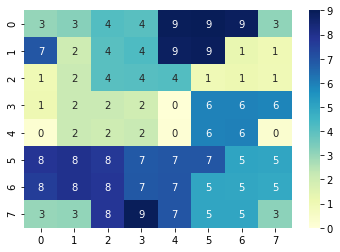

In [15]:
labels = labels_val
ones = np.ones((len(np.reshape(k_all, (-1)))))
clust_matr1 = np.zeros(som_dim[0]*som_dim[1])
for i in range(som_dim[0]*som_dim[1]):
    s1 = np.sum(labels[np.where(np.reshape(k_all, (-1))==i)]) / np.sum(ones[np.where(np.reshape(k_all, (-1))==i)])
    clust_matr1[i] = s1
clust_matr1 = np.reshape(clust_matr1, (som_dim[0],som_dim[1]))
ax = sns.heatmap(clust_matr1, cmap="YlGnBu", vmin=0,vmax=9, annot=True, fmt=".0f")
plt.show()

### Reconstructions:

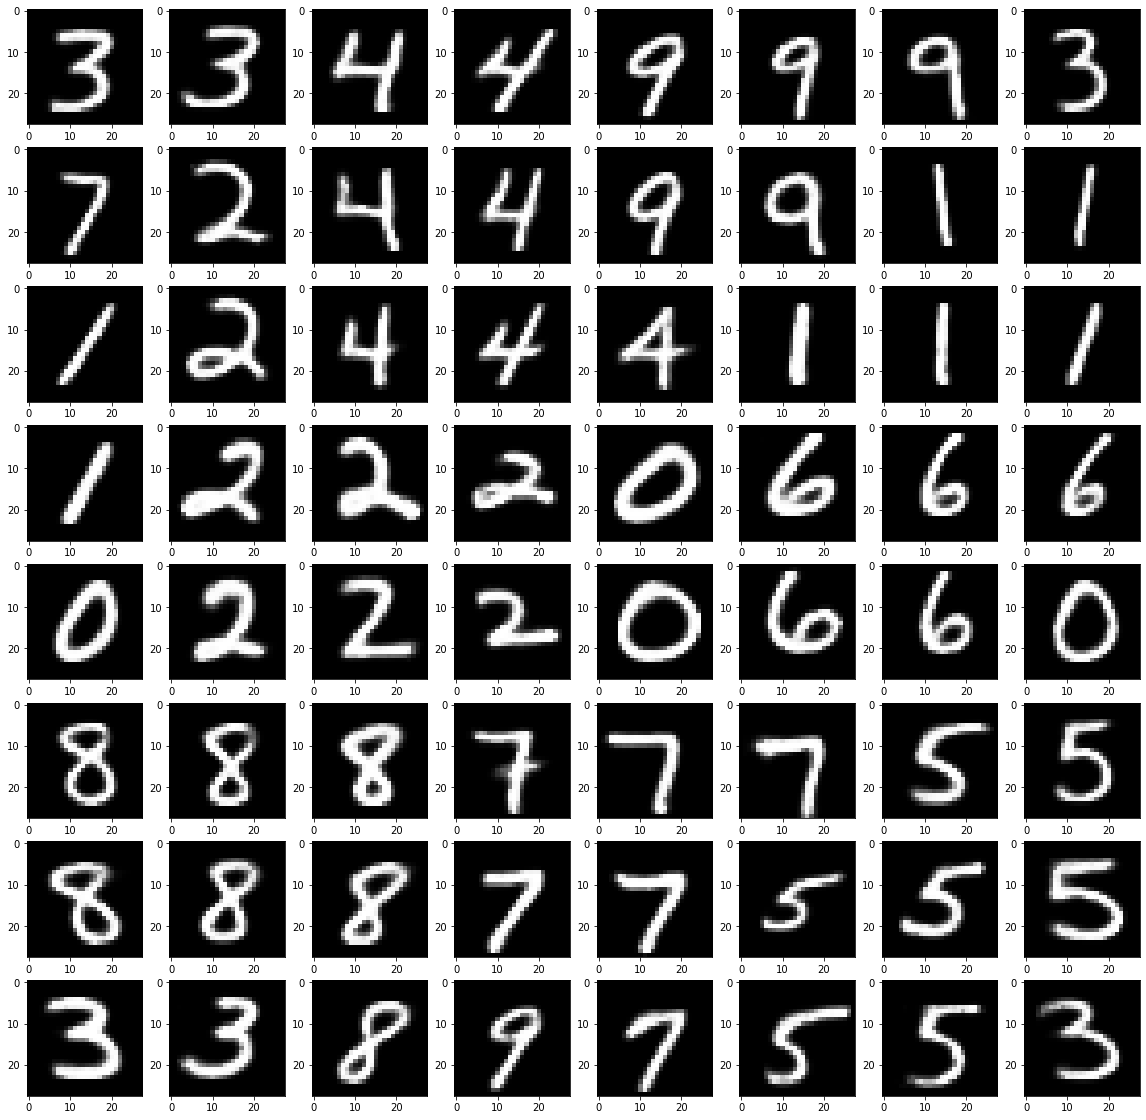

In [16]:
fig, axes = plt.subplots(8, 8, figsize=(20,20))
for i in range(8):
    for j in range(8):
        axes[i,j].imshow(x_hat_all[i,j], cmap='gray')